In [10]:
import os
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import h5py

from hybridfactory.data import dataset as dset
from hybridfactory.probes import probe as prb
from hybridfactory.generate import generator

In [11]:
%matplotlib notebook

In [45]:
# ----------User params------------
# Start by resaving the chanMap.mat file used for the KS2 from matlab as v7.3 (necessary to read in with h5py)
# Path to new chanMap file 
chanMapPath = r'C:\Users\labadmin\Documents\jic\hbf_fork\SC026_080819_20min\chanMap_v7p3.mat'
# total number of channels in the binary file. The KS2 channel map is often defined w/out including the digital channel
Ntot = 385 

# Path to binary
binaryPath = r'C:\Users\labadmin\Documents\jic\hbf_fork\SC026_080819_20min\SC026_080819_g0_20min.imec2.ap.bin'

# Path to phy output
phyPath = r'C:\Users\labadmin\Documents\jic\hbf_fork\SC026_080819_20min\csb101'

# Selected single unit index (pick from phy)
phy_unit = 208
test_unit = phy_unit + 1     # hybridfactory uses 1 based unit indicies

# Number of channels to save (e.g. 4 for a mock tetrode)
# For standard KS2 output, must be <= 15
num_neighbor = 4

# output path for npy file of denoised waveforms (needs to exist)
outPath = r'C:\Users\labadmin\Documents\jic\hbf_fork\SC026_waves_out'

# build probe data.
chanMap = h5py.File(chanMapPath, 'r')                
channel_map = np.squeeze(chanMap.get('chanMap')[:])
channel_map = channel_map.astype('int')
connected = np.squeeze(chanMap.get('connected')[:])
connected = connected.astype('int')
xc = np.squeeze(chanMap.get('xcoords')[:])
yc = np.squeeze(chanMap.get('ycoords')[:])
channel_map = channel_map - 1   # convert to 0 based for python
nMap = channel_map.shape[0]
if (nMap < Ntot):
    diffChan = Ntot - nMap
    maxChan = np.amax(channel_map)
    extraChan = np.arange(maxChan + 1, maxChan + 1 +diffChan)
    channel_map = np.append(channel_map, extraChan)
    connected = np.append(connected, np.zeros((diffChan,))) #append zeros for extra chans to connected
    xc = np.append(xc, np.nan*np.ones((diffChan,)))
    yc = np.append(yc, np.nan*np.ones((diffChan,)))      #append NaN for extra chans in coordinates


channel_positions = np.hstack((xc[:, np.newaxis], yc[:, np.newaxis]))
connected = connected.astype('bool')

currPrb = prb.custom_probe(channel_map, connected, channel_positions)

#currPrb = prb.custom_probe(channel_map, connected)


In [46]:
np.random.seed(10191)

In [47]:
currAnnot = phyPath
dtype = np.int16
sample_rate = 30000
probe = currPrb
source = dset.new_annotated_dataset(binaryPath, dtype, sample_rate, probe, phyPath, "phy")

# essentially the same sort of object as annotated_dataset, but svdgen can only work with hybrid
hybrid = dset.new_hybrid_dataset(source, outPath, copy=False)

In [ ]:
# create the generator object
svdgen = generator.SVDGenerator(hybrid, samples_before=20, samples_after=40)

# get events from raw data, run SVD on derivatives, get top 6 components
events = svdgen.construct_events(test_unit, 6)

# calculate mean waveforms to find max channel
meanWave = np.mean(events,2)
vpp = np.amax(meanWave,1) - np.amin(meanWave,1)
maxChan = np.argmax(vpp)
source_chan = source.unit_channels(test_unit, currPrb, 20, 40)

# find 3 closest channels to max_source_channel
source_pos = currPrb.channel_positions[source_chan,:]
dist_sq = pow((source_pos[:,0]-source_pos[maxChan,0]),2) + pow((source_pos[:,1]-source_pos[maxChan,1]),2)
sorted_chan = np.argsort(dist_sq)
select_chan = sorted_chan[0:num_neighbor]
events_select_chan = events[select_chan,:,:]

outName = 'unit_' + repr(phy_unit) + '.npy'
outFullPath = op.join(outPath, outName)
np.save(outFullPath, events_select_chan)


calling construct_events


In [42]:
# get time windows to plot a single raw waveform

chanmap = source.probe.connected_channels()
uw = source.unit_windows(test_unit, 20, 40)

<IPython.core.display.Javascript object>


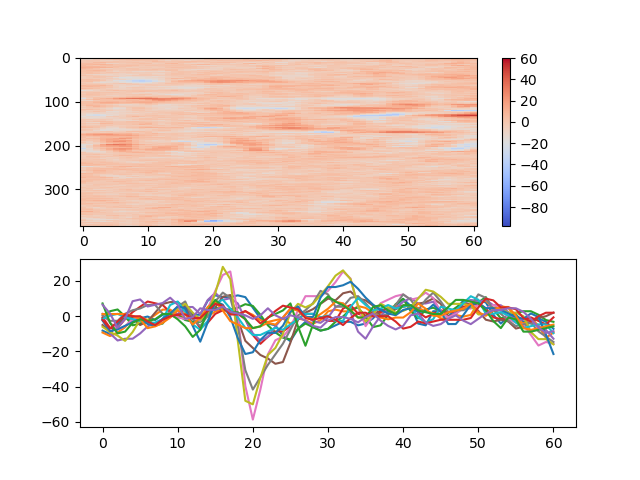

In [43]:
# plot raw data for a single event in the unit
testEvent = 0  # event index; needs to be in range

plt.figure()

plt.subplot(2, 1, 1)
plt.imshow(uw[chanmap, :, 0], cmap="coolwarm", aspect="auto", interpolation="nearest")
plt.colorbar()

plt.subplot(2, 1, 2)
plt.plot(uw[source_chan, :, testEvent].T)

<IPython.core.display.Javascript object>


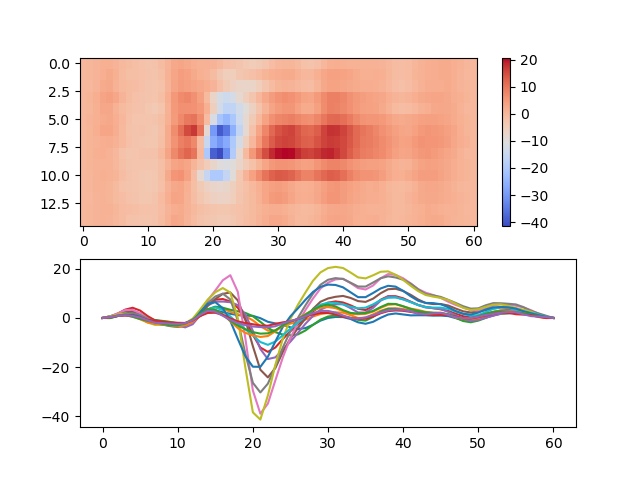

In [44]:
# plot denoised waveforms for the sample event
plt.figure()

plt.subplot(2, 1, 1)
plt.imshow(events[:, :, testEvent], cmap="coolwarm", aspect="auto", interpolation="nearest")
plt.colorbar()

plt.subplot(2, 1, 2)
plt.plot(events[:,:,testEvent].T)